# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [2]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
from src.utils.poolgraph import PoolGraph


%load_ext autoreload
%autoreload 2

In [3]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
(
    pool,
    controller,
    collateral_token,
    stablecoin,
    aggregator,
    stableswap_pools,
    peg_keepers,
    policy,
    factory,
) = get(ETH_POOL, bands_data="controller")

In [4]:
# Verify snapshot context works on StableSwap pools from crvusdsim
i, j = 1, 0

stableswap_pool = stableswap_pools[2]
high = stableswap_pool.get_max_trade_size(i, j)
prev_bals = stableswap_pool.balances.copy()

print("Pre Trade")
print("Balances", prev_bals)
print("High", high)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
print()

with stableswap_pool.use_snapshot_context():
    amt_out = stableswap_pool.trade(i, j, high)
    swap_bals = stableswap_pool.balances.copy()
    print("Post Trade")
    print("Amount out", amt_out)
    print("Balances", swap_bals)
    print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])
    print()

new_bals = stableswap_pool.balances.copy()
print("After reversing snapshot context")
print("Balances", new_bals)
print("Allowance", stableswap_pool.coins[0].balanceOf[stableswap_pool.address])

assert prev_bals == new_bals, (prev_bals, new_bals)
assert swap_bals != new_bals

Pre Trade
Balances [10114723654034, 25767074910220216366569187]
High 12918808792401666455492325
Allowance 10114723654034

Post Trade
Amount out 10012575059851
Balances [101647915363, 38685883702621882822061512]
Allowance 102148594183

After reversing snapshot context
Balances [10114723654034, 25767074910220216366569187]
Allowance 10114723654034


In [5]:
# Generate markets and prices
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths("../" + scenario.price_config)
scenario.update_market_prices(prices[-1])

[INFO][23:18:47][root]-542810: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][23:18:47][root]-542810: Fetching 1inch quotes.
[INFO][23:18:52][root]-542810: We have 436320 quotes.
[INFO][23:18:52][root]-542810: Fitting external markets against 1inch quotes.
[INFO][23:18:52][root]-542810: Reading price config from ../src/configs/prices/1h_1696108632_1701289032.json.


In [12]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = list(markets.values())
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 20 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 15


In [13]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][23:21:27][root]-542810: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0xca978a0528116dda3cba9acd3e68bc6191ca53d0 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDP), i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x4dece678ceceb27446b35c672dc7d61f30bad69e chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDC), i=1, j=0, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=<SimCurveStableSwapPool address=0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0 chain=mainnet>, i=0, j=1, amt=None), Swap(pool=<SimCurveStableSwapPool address=0x390f3595bca2df7d23783dfd126427cceb997bf4 chain=mainnet>, i=1, j=0, amt=None), Swap(pool=External Market (TUSD, USDT), i=1, j=0

In [17]:
# TODO handle failures:
# 1. `trade` method has diff outputs for diff pool types
# 2. LLAMMA snapshot context doesn't snapshot ERC20 balances
# 3. LLAMMA has no attribute `get_max_trade_size`

df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(1, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

[ERROR][23:22:22][root]-542810: Cycle 3 failed to optimize: can't multiply sequence by non-int of type 'float'
[ERROR][23:22:24][root]-542810: Cycle 7 failed to optimize: can't multiply sequence by non-int of type 'float'
[ERROR][23:22:27][root]-542810: Cycle 11 failed to optimize: can't multiply sequence by non-int of type 'float'
[ERROR][23:22:29][root]-542810: Cycle 15 failed to optimize: can't multiply sequence by non-int of type 'float'
[ERROR][23:22:29][root]-542810: Cycle 16 failed to optimize: 'SimLLAMMAPool' object has no attribute 'get_max_trade_size'
[ERROR][23:22:29][root]-542810: Cycle 17 failed to optimize: 'SimLLAMMAPool' object has no attribute 'get_max_trade_size'
[ERROR][23:22:29][root]-542810: Cycle 18 failed to optimize: 'SimLLAMMAPool' object has no attribute 'get_max_trade_size'
[ERROR][23:22:29][root]-542810: Cycle 19 failed to optimize: 'SimLLAMMAPool' object has no attribute 'get_max_trade_size'


,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,1696025215737964527616,1,-4.201,0.0
1,26237383554444650610688,1,-10.312,0.0
2,143365728069721320849408,1,-140.335,0.0
4,109530653270562362621952,125998074880190425595904,134.837,139.0
5,394252920932042228629504,480782127832305573560320,402.776,396.0
6,275083205386384548298752,427730306830120117075968,261.169,232.0
8,2601355159.0,1.0,-0.207,0.0
9,184.0,1.0,-0.000,0.0
10,2445.0,1.0,-0.000,0.0
12,47509281421.0,1.0,4.919,0.0


Best amount linspace: 1
Best profit linspace: -1e-18
Best amount optimize: 1696025215737964527616
Best profit optimize: -4.2008824741730715


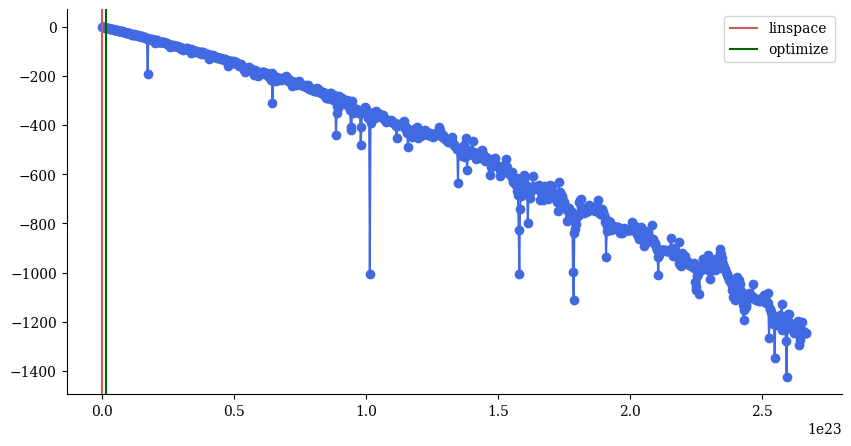

In [16]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing)

i = 0
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j) / 10
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue")
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# ax.set_xlim(0, 919573381759 * 2)
# ax.set_ylim(-1000, 1000)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")